In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

import sys
sys.path.append('/Users/austin/Documents/GitHub/atomai')
import atomai as aoi
print(aoi.__version__)

import torch
from torch.utils.data import DataLoader
from scipy.ndimage import gaussian_filter

0.7.8.MAC


In [2]:
expdata = np.load('exp_data.npy')
expdata = expdata-expdata.min()
#expdata = gaussian_filter(expdata,sigma=8)

In [3]:
image_dim = 512
dataset = np.load('../PdSeM_train_test_512_4class.npz')
images = dataset['X_train'].reshape(-1,1,image_dim,image_dim)
labels = dataset['y_train'].reshape(-1,image_dim,image_dim)
images_test = dataset['X_test'].reshape(-1,1,image_dim,image_dim)
labels_test = dataset['y_test'].reshape(-1,image_dim,image_dim)

print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)



(2368, 1, 512, 512) (2368, 512, 512)
(832, 1, 512, 512) (832, 512, 512)


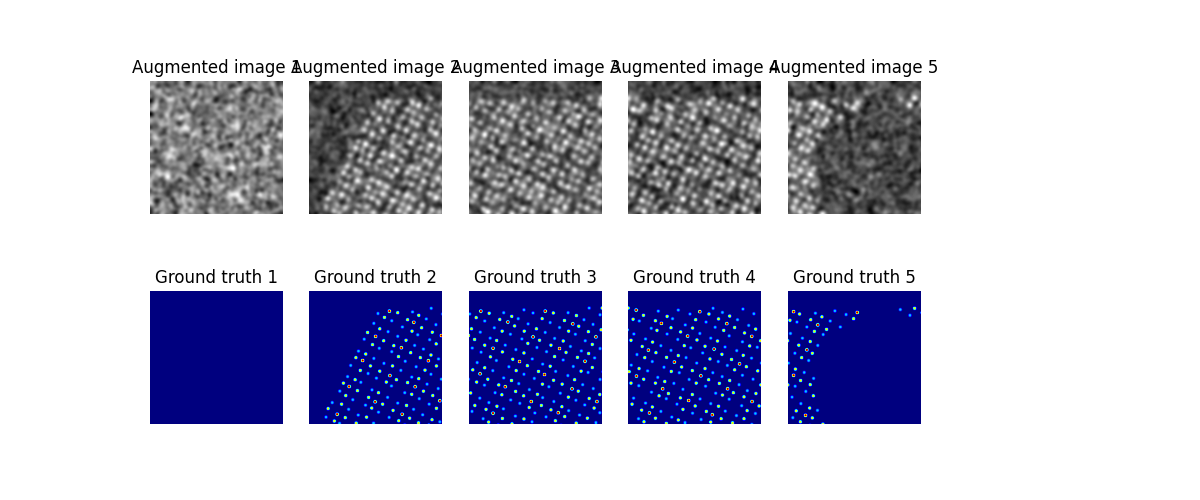

In [4]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(12, 5))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax.set_axis_off()
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)
    ax.set_axis_off()

In [5]:
model = aoi.models.Segmentor(nb_classes=4)
# print(model.net)

Epoch 1/1000 ... Training loss: 1.6835 ... Test loss: 1.6152 ... Train Accuracy: 0.2307 ... Test Accuracy: 0.2381 ... GPU memory usage: N/A / N/A
Epoch 100/1000 ... Training loss: 0.7042 ... Test loss: 0.371 ... Train Accuracy: 0.5165 ... Test Accuracy: 0.5155 ... GPU memory usage: N/A / N/A
Epoch 200/1000 ... Training loss: 0.216 ... Test loss: 0.1851 ... Train Accuracy: 0.6787 ... Test Accuracy: 0.414 ... GPU memory usage: N/A / N/A
Epoch 300/1000 ... Training loss: 0.1142 ... Test loss: 0.1078 ... Train Accuracy: 0.7275 ... Test Accuracy: 0.7032 ... GPU memory usage: N/A / N/A
Epoch 400/1000 ... Training loss: 0.0828 ... Test loss: 0.0897 ... Train Accuracy: 0.7341 ... Test Accuracy: 0.7263 ... GPU memory usage: N/A / N/A
Epoch 500/1000 ... Training loss: 0.0656 ... Test loss: 0.0702 ... Train Accuracy: 0.7318 ... Test Accuracy: 0.7396 ... GPU memory usage: N/A / N/A
Epoch 600/1000 ... Training loss: 0.0569 ... Test loss: 0.0588 ... Train Accuracy: 0.7734 ... Test Accuracy: 0.6682 .

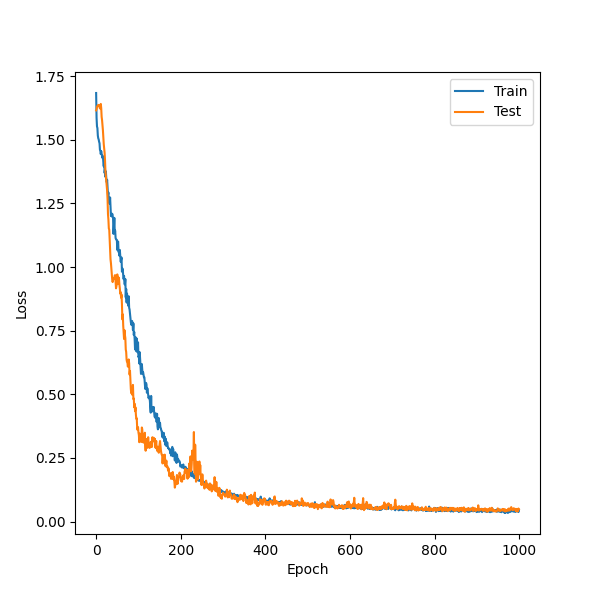

In [6]:
model.fit(images, labels, images_test, labels_test, training_cycles=1000, compute_accuracy=True, swa=True, batch_size=32)

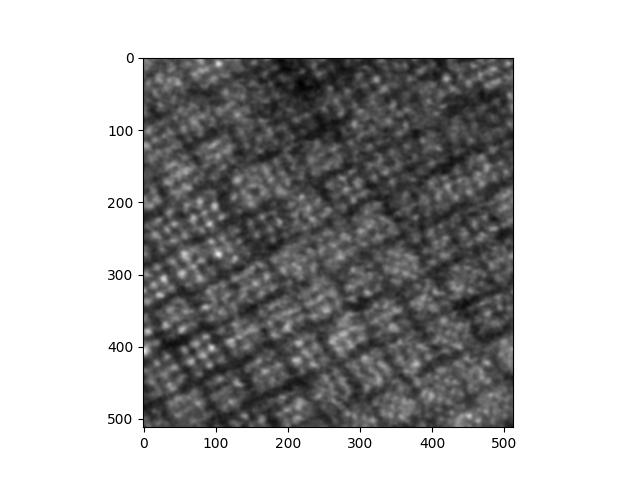

In [35]:
input512 = expdata.T[1536:2048,1024:1536]
input512 = 7*gaussian_filter(input512, sigma=2)
plt.figure()
plt.imshow(input512, cmap='gray')

In [36]:
nn_output, coordinates = model.predict(input512)

Batch 1/1
1 image was decoded in approximately 0.1532 seconds


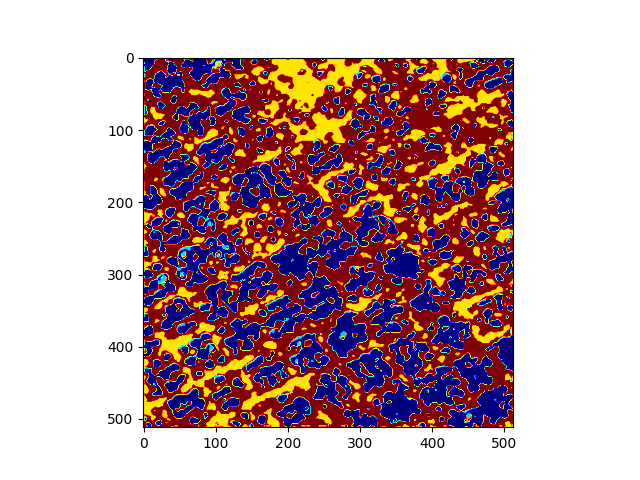

In [37]:
plt.figure()
plt.imshow(np.argmax(nn_output,axis=3).reshape((512,512)),cmap='jet')

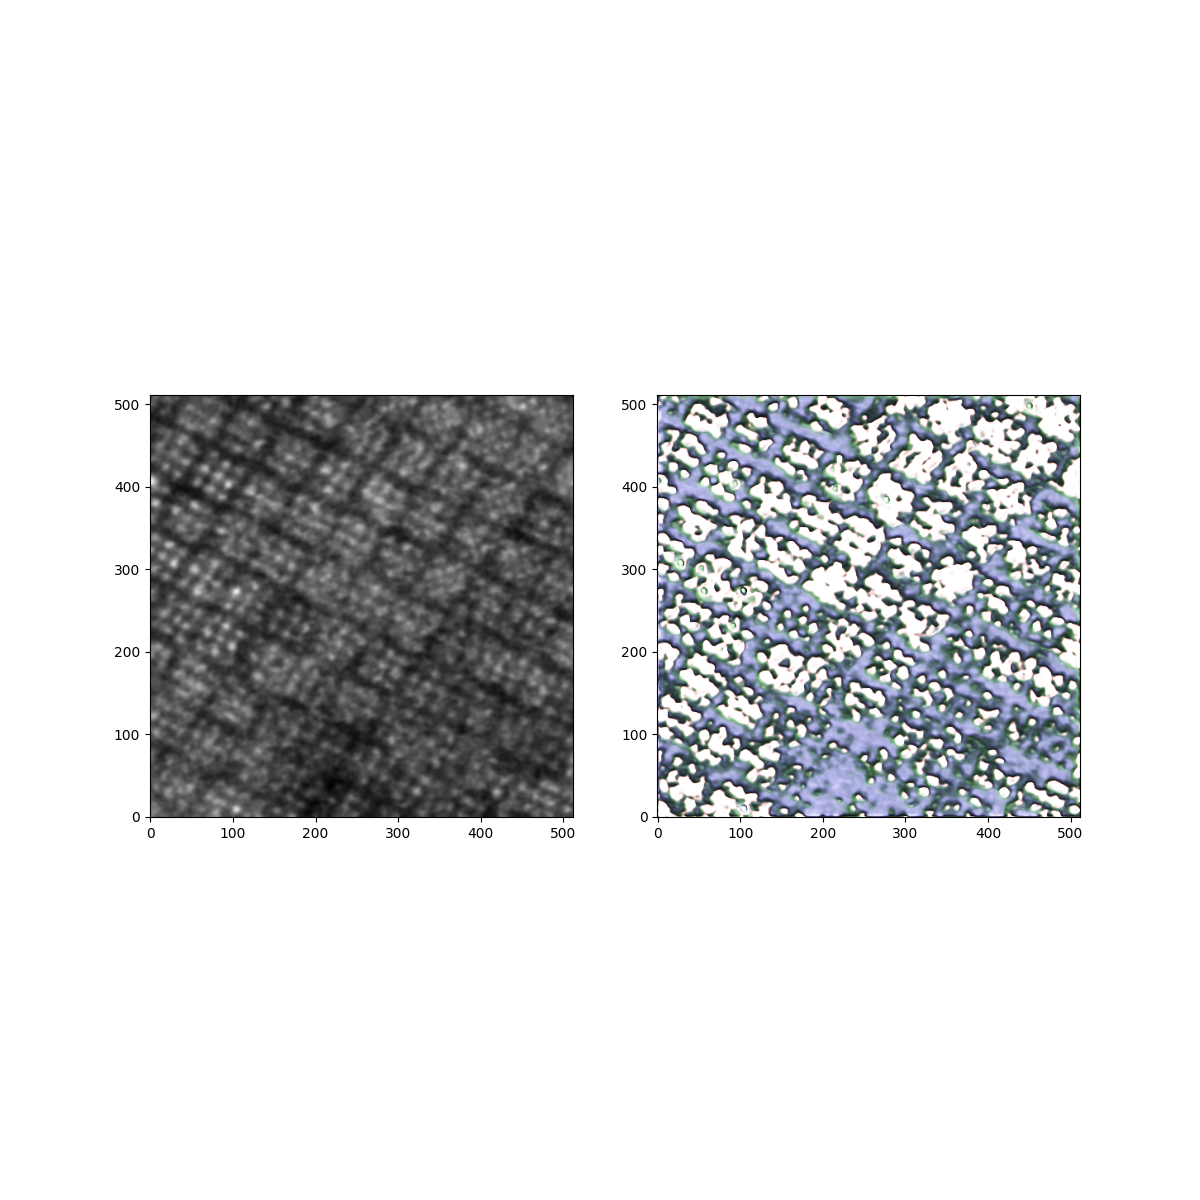

In [38]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(input512, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

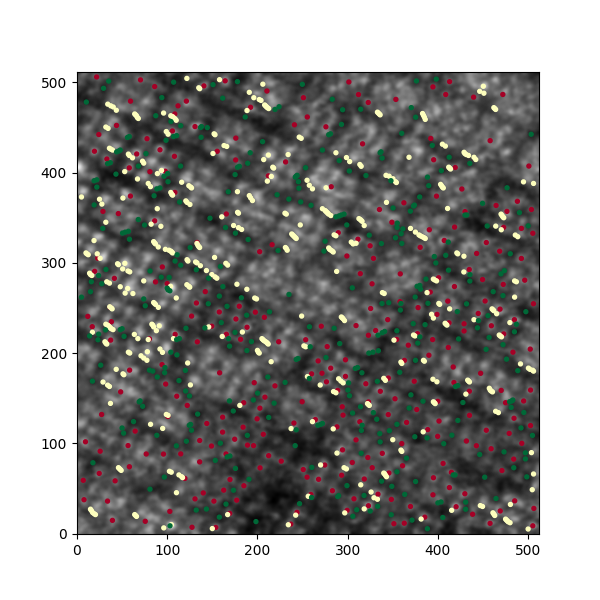

In [40]:
aoi.utils.plot_coord(input512, coordinates[0], fsize=6)

In [ ]:
import torch
torch.save(model, f='drive/MyDrive/Colab Notebooks/model2048.pt')